<a href="https://colab.research.google.com/github/oluwamayowaa/Cars-45-assignment/blob/main/data_science_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime
import math
import pickle
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# seaborn style settings
sns.set_theme(context= 'paper', style= 'whitegrid', palette= 'pastel', font= 'monospace', font_scale= 1)

## Loading the dataset

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/ds assignment/Cars_Data_CSV.csv')

In [ ]:
data.head()

,make,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,transmission,door_count,seat_count,fuel_type,date_created,price_NGN
0,audi,NaN,330000.00,1995,2600.00,110.00,compact,NaN,auto,NaN,NaN,gasoline,2015-11-14 20:10:48.033192+00,873428
1,audi,200,NaN,1995,NaN,NaN,compact,NaN,NaN,NaN,NaN,gasoline,2015-11-14 20:11:19.607788+00,66616
2,audi,NaN,NaN,1995,11199.00,NaN,compact,NaN,NaN,NaN,NaN,gasoline,2015-11-14 20:11:20.320579+00,66616
3,audi,NaN,NaN,1995,NaN,NaN,compact,NaN,NaN,NaN,NaN,gasoline,2015-11-14 20:11:21.801285+00,66604
4,audi,a6,347000.00,1995,NaN,85.00,compact,NaN,auto,NaN,NaN,gasoline,2015-11-14 20:12:41.082787+00,843820


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638562 entries, 0 to 638561
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   make                 638562 non-null  object 
 1   model                454990 non-null  object 
 2   mileage              603981 non-null  float64
 3   manufacture_year     638562 non-null  int64  
 4   engine_displacement  489134 non-null  float64
 5   engine_power         537375 non-null  float64
 6   body_type            72636 non-null   object 
 7   color_slug           0 non-null       float64
 8   transmission         541441 non-null  object 
 9   door_count           451206 non-null  float64
 10  seat_count           409865 non-null  float64
 11  fuel_type            638562 non-null  object 
 12  date_created         638562 non-null  object 
 13  price_NGN            638562 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 68.2+ MB


In [ ]:
# converting the date_created column to the appropriate dtype
data['date_created'] = pd.to_datetime(data['date_created'])

In [ ]:
# dropping the color_slug column because all the values are missing
data.drop('color_slug', axis=1, inplace=True)

In [ ]:
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 638562
Number of columns: 13


In [ ]:
df= data.copy()

In [ ]:
df.pop('price_NGN')
df['price']= data['price_NGN']

In [ ]:
# desciptive statistics of non-numerical columns
df.describe(include= ['object']).T

,count,unique,top,freq
make,638562,37,mercedes-benz,78624
model,454990,587,octavia,20853
body_type,72636,2,compact,72530
transmission,541441,2,man,360588
fuel_type,638562,2,gasoline,340676


In [ ]:
# descriptive statistics of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mileage,603981.00,115283.86,365012.42,0.00,22000.00,82500.00,150000.00,9999999.00
manufacture_year,638562.00,2008.72,5.50,1995.00,2005.00,2010.00,2014.00,2016.00
engine_displacement,489134.00,2100.23,1931.07,10.00,1461.00,1898.00,2143.00,32000.00
engine_power,537375.00,105.05,53.30,3.00,73.00,94.00,125.00,999.00
door_count,451206.00,3.68,0.84,1.00,4.00,4.00,4.00,6.00
seat_count,409865.00,4.87,0.86,1.00,5.00,5.00,5.00,74.00
price,638562.00,6171796.44,179858592.43,16.00,1600592.00,3980296.00,7377492.00,82310297260.00


## Data Cleaning.

### Handling missing values.

In [ ]:
# finding the percentage of missing values in each column
missing= df.isna().mean() .round(4) * 100
missing.to_frame(name= '%')

,%
make,0.00
model,28.75
mileage,5.42
manufacture_year,0.00
engine_displacement,23.40
engine_power,15.85
body_type,88.63
transmission,15.21
door_count,29.34
seat_count,35.81


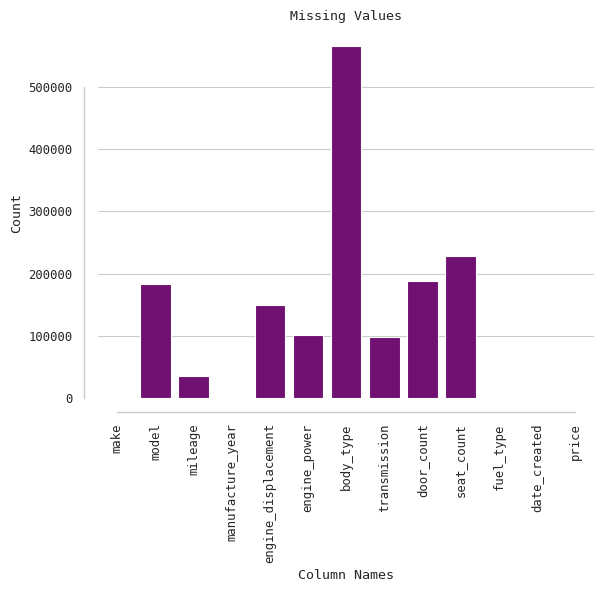

In [ ]:
# plotting a bar chart of missing value columns

sns.barplot(x= df.isna().sum().index, y= df.isna().sum().values, color= 'purple')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 90)
plt.ylabel('Count')
plt.xlabel('Column Names')
plt.title('Missing Values')
plt.show()

**Model**

In [ ]:
df.loc[df['model'].isna()][600:610]

,make,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,fuel_type,date_created,price
1024,bmw,NaN,243000.00,1995,2793.00,142.00,NaN,man,2.00,4.00,gasoline,2015-12-17 17:09:22.691761+00:00,1600192
1025,bmw,NaN,203531.00,1995,NaN,NaN,NaN,NaN,NaN,NaN,gasoline,2015-12-17 17:37:17.000718+00:00,1120416
1026,bmw,NaN,228300.00,1995,1995.00,120.00,compact,man,NaN,NaN,diesel,2015-12-17 20:46:20.996034+00:00,3227240
1027,bmw,NaN,97000.00,1995,NaN,NaN,NaN,NaN,NaN,NaN,gasoline,2015-12-17 21:04:06.321946+00:00,1800740
1028,bmw,NaN,245000.00,1995,1991.00,110.00,NaN,man,2.00,4.00,gasoline,2015-12-17 23:52:58.027665+00:00,400164
1029,bmw,NaN,216000.00,1995,1596.00,75.00,NaN,man,4.00,5.00,gasoline,2015-12-18 01:04:33.728322+00:00,480192
1030,bmw,NaN,191300.00,1995,1596.00,75.00,compact,man,NaN,NaN,gasoline,2015-12-18 08:20:03.915018+00:00,368616
1031,bmw,NaN,290000.00,1995,NaN,NaN,NaN,NaN,NaN,NaN,gasoline,2015-12-18 11:53:10.536103+00:00,279720
1032,bmw,NaN,248000.00,1995,2493.00,147.00,NaN,man,4.00,5.00,gasoline,2015-12-18 13:13:52.834678+00:00,2200488
1033,bmw,NaN,NaN,1995,NaN,NaN,compact,NaN,NaN,NaN,gasoline,2015-12-18 15:25:03.379604+00:00,666172


A quick examination of the dataset reveals that the rows with missing values in the model column are associated with the vehicle's `make` and  `manyfacture_year`.  

It's also worth noting that the `fuel_type` column contains no null values. By combining information from the `make`, `manufacture_year`, and `fuel_type` columns, we can infer the correct model name based on other non-null entries in the dataset.

In [ ]:
#def multiple_modes (column):
#    modes= column.mode()
#    if not modes.empty:
#        return modes.iloc[0]
#    return None

In [ ]:
#grouped_model= df.groupby(['make', 'manufacture_year'])['model'].agg(
#    lambda x: x.mode().iloc[0] if not x.mode().empty
#    else x.unique()[0] if not x.isnull().all()
#    else None)

In [ ]:
grouped_model= df.groupby(
    ['make', 'manufacture_year', 'fuel_type'])['model'].apply(
        lambda x: x.mode().iloc[0]
        if not x.mode().empty
        else np.nan)
grouped_model= pd.DataFrame(grouped_model)

In [ ]:
df.set_index(['make', 'manufacture_year', 'fuel_type'], inplace= True)
df['model']= df['model'].fillna(grouped_model['model'])
df.reset_index(inplace= True)

In [ ]:
df['model'].isna().sum()

496

The entries that remain empty lack a recorded model for any combination of `make`, `manufacture_year`, and `fuel type`.


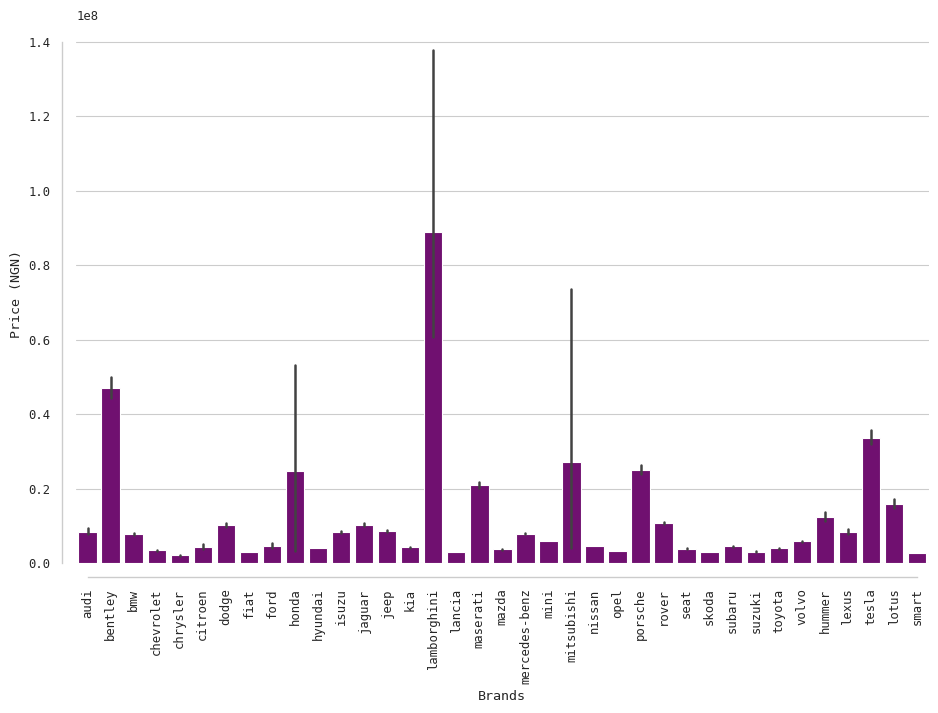

In [ ]:
plt.subplots(figsize= (11, 7))
sns.barplot(df, x='make', y='price', color= 'purple')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 90)
plt.ylabel('Price (NGN)')
plt.xlabel('Brands')
plt.show()

From the bar plot, we can see that Lamborhini is the most expensive brand on average, while Chrysler is the least expensive.

**Body type**

In [ ]:
df['body_type'].value_counts()

body_type
compact    72530
van          106
Name: count, dtype: int64

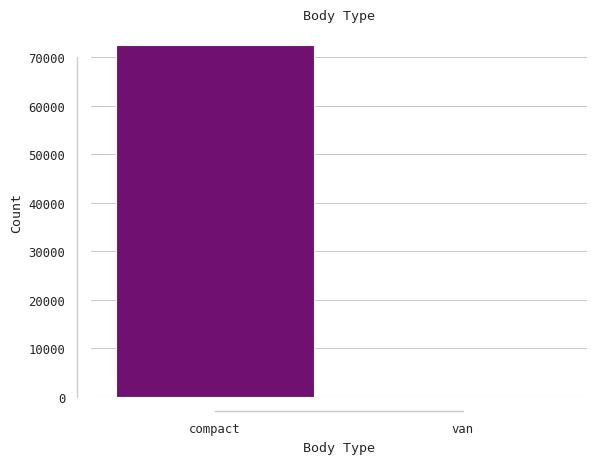

In [ ]:
sns.countplot(df, x= 'body_type', color= 'purple')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 0)
plt.title('Body Type')
plt.ylabel('Count')
plt.xlabel('Body Type')
plt.show()

**Transmission**

In [ ]:
df.replace({'transmission': {'man': 'manual', 'auto': 'automatic'}}, inplace= True) # replacing the transmission values to be spelt in full.
df['transmission'].value_counts()

transmission
manual       360588
automatic    180853
Name: count, dtype: int64

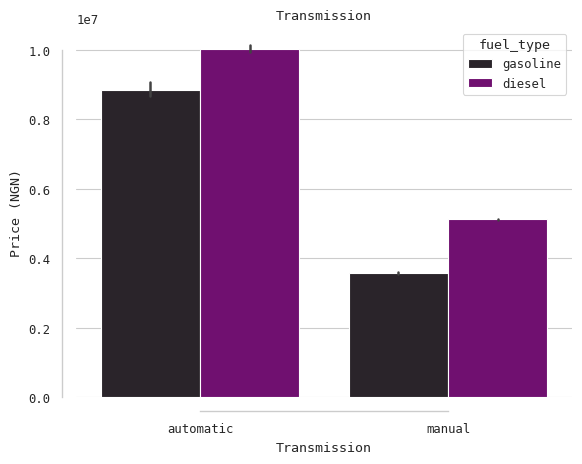

In [ ]:
sns.barplot(df, x= 'transmission', y= 'price', hue= 'fuel_type', palette= 'dark:purple')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 0)
plt.title('Transmission')
plt.ylabel('Price (NGN)')
plt.xlabel('Transmission')
plt.show()

Automatic transmissions are associated with higher prices for both fuel types. Also, diesel cars generally command higher prices than gasoline cars within the same transmission type

Extending the same approach used for inferring the vehicle model, I'll apply it to the `body_type`, `transmission`, `door_count`, and `seat_count` columns. This involves leveraging data from other cars in the dataset with matching `make`, `manufacture_year`, and `fuel_type`. 🚗

In [ ]:
# Body type
grouped_body= df.groupby(
    ['make', 'manufacture_year', 'fuel_type'])['body_type'].apply(
        lambda x: x.mode().iloc[0]
        if not x.mode().empty
        else np.nan)
grouped_body= pd.DataFrame(grouped_body)

# Transmission
grouped_transmission= df.groupby(
    ['make', 'manufacture_year', 'fuel_type'])['transmission'].apply(
        lambda x: x.mode().iloc[0]
        if not x.mode().empty
        else np.nan)
grouped_transmission= pd.DataFrame(grouped_transmission)

#Door count
grouped_doors= df.groupby(
    ['make', 'manufacture_year', 'fuel_type'])['door_count'].apply(
        lambda x: x.mode().iloc[0]
        if not x.mode().empty
        else np.nan)
grouped_doors= pd.DataFrame(grouped_doors)

# Seat count
grouped_seats= df.groupby(
    ['make', 'manufacture_year', 'fuel_type'])['seat_count'].apply(
        lambda x: x.mode().iloc[0]
        if not x.mode().empty
        else np.nan)
grouped_seats= pd.DataFrame(grouped_seats)

In [ ]:
df= df.set_index(['make', 'manufacture_year', 'fuel_type'])
df['body_type']= df['body_type'].fillna(grouped_body['body_type'])
df['transmission']= df['transmission'].fillna(grouped_transmission['transmission'])
df['door_count']= df['door_count'].fillna(grouped_doors['door_count'])
df['seat_count']= df['seat_count'].fillna(grouped_seats['seat_count'])

df = df.reset_index()

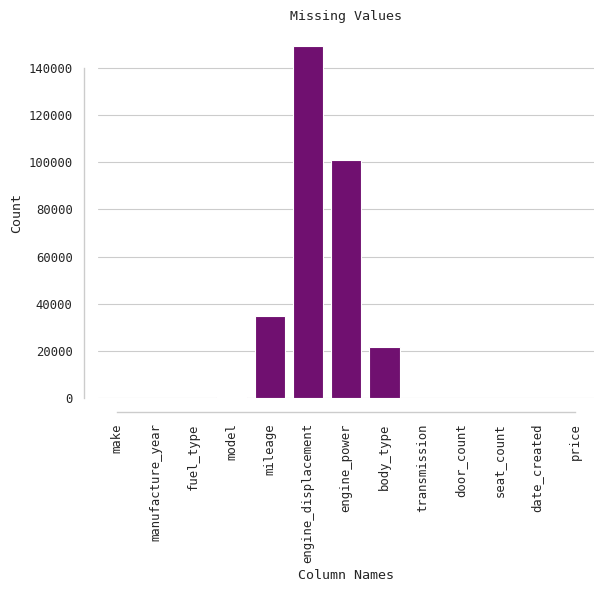

In [ ]:
sns.barplot(x= df.isna().sum().index, y= df.isna().sum().values, color= 'purple')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 90)
plt.ylabel('Count')
plt.xlabel('Column Names')
plt.title('Missing Values')
plt.show()

### Handling Outliers.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
manufacture_year,638562.00,2008.72,5.50,1995.00,2005.00,2010.00,2014.00,2016.00
mileage,603981.00,115283.86,365012.42,0.00,22000.00,82500.00,150000.00,9999999.00
engine_displacement,489134.00,2100.23,1931.07,10.00,1461.00,1898.00,2143.00,32000.00
engine_power,537375.00,105.05,53.30,3.00,73.00,94.00,125.00,999.00
door_count,638458.00,3.75,0.79,1.00,4.00,4.00,4.00,6.00
seat_count,638428.00,4.88,0.75,1.00,5.00,5.00,5.00,74.00
price,638562.00,6171796.44,179858592.43,16.00,1600592.00,3980296.00,7377492.00,82310297260.00


Key observations based on the information obtained:

1. The dataset exhibits a significant disparity between the maximum and minimum car prices.
2. The `mileage` column also displays a substantial range between its third quantile and maximum values, indicating the presence of potential outliers. Same with `engine_displacement`.

4. A maximum value of 999 HP for `engine_power` is also very high. While some cars might pack such power, one could assume that this is a data entry error.


**Price.**

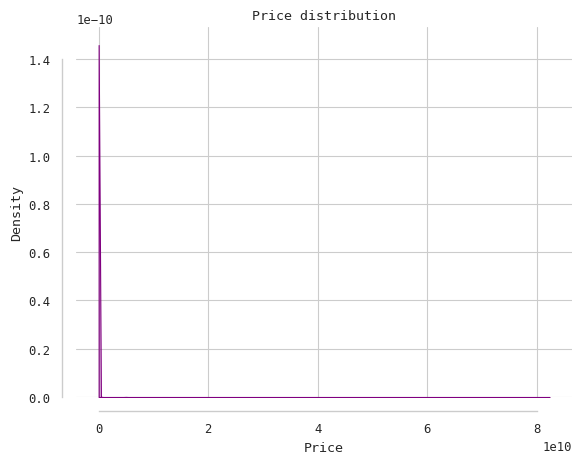

In [ ]:
sns.kdeplot(df, x= 'price', fill= True, color= 'purple')
sns.despine(offset=10, trim=True)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [ ]:
print(f'There are {df.make.nunique()} distinct car brands in the dataset.')
print(f'These are: {df.make.unique()}')

There are 37 distinct car brands in the dataset.
These are: ['audi' 'bentley' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dodge' 'fiat'
 'ford' 'honda' 'hyundai' 'isuzu' 'jaguar' 'jeep' 'kia' 'lamborghini'
 'lancia' 'maserati' 'mazda' 'mercedes-benz' 'mini' 'mitsubishi' 'nissan'
 'opel' 'porsche' 'rover' 'seat' 'skoda' 'subaru' 'suzuki' 'toyota'
 'volvo' 'hummer' 'lexus' 'tesla' 'lotus' 'smart']


When dealing with outliers in the dataset, it's important to recognize that pricing can vary significantly across different car brands. Therefore, a one-size-fits-all approach won't suffice. Instead, we need to address outliers on a brand-specific basis.

Taking the *Audi*, which is the first brand in the dataset as an example:

In [ ]:
audi_df= df.loc[df['make'] == 'audi'].reset_index(drop= True)

In [ ]:
pd.DataFrame(audi_df.groupby('model').agg({'price': ['min', 'max']}))

price             
                 min          max
model                            
100            22204     33304928
200               16     36861584
80                88     60176904
90            281272     43672052
a1                44     48055516
a2            340192     10000712
a3                16  40004440756
a4                16    164487208
a4-allroad    503332     19924100
a5             14788     25183732
a6                16    444608884
a6-allroad        16     69563288
a7               120     35799972
a8                16     70548440
coupe             16     56016580
q3             44012     24185700
q5             29608     39605864
q7             22204     36994820
r8           3762088     78008660
rs2          4762648     20002560
rs3          6203448     28637988
rs4           839912     43612908
rs5           460132     29170792
rs6             1644     56310732
rs7         26495500     48672804
s3             10364     25047416
s4            207252     22833736
s5           5960888     27054404
s6           1000076     31211548
s7          15091428     29176432
s8            962252     52306336
sq5          8396936     31163464
tt               148     47042604
v8           1320148     13201376

The dataset contains an Audi with a price exceeding 40 billion naira, as well as some priced at 16 naira. These extreme values validate earlier hypotheses.

**Interquartile range method.**

In [ ]:
q1= audi_df['price'].quantile(0.25)
q3= audi_df['price'].quantile(0.75)
IQR= q3 - q1
lower_fence= q1 - (1.5 * IQR)
upper_fence= q3 + (1.5 * IQR)

print(f'q1: {q1}')
print(f'q3: {q3}')
print(f'IQR: {IQR}')
print(f'lower_fence: {lower_fence}')
print(f'upper_fence: {upper_fence}')

q1: 3300488.0
q3: 10460356.0
IQR: 7159868.0
lower_fence: -7439314.0
upper_fence: 21200158.0


The interquartile range method cannot be applied to the outliers because the lower fence results in a negative value, which is inapplicable to car prices.

**Percentile capping.**

In [ ]:
def cap_prices (dataset):
    ''' This function would loop through each car make in the dataset and winsorize between the 5th and 95th percentiles.'''

    for i in dataset.make.unique().tolist():
        x= dataset.loc[dataset['make'] == i]
        upper_price_cap= round(x['price'].quantile(0.95))
        lower_price_cap= round(x['price'].quantile(0.05))

        # replacing outliers with capped values.
        dataset.loc[(dataset['make'] == i) & (dataset['price'] > upper_price_cap), 'price'] = upper_price_cap
        dataset.loc[(dataset['make'] == i) & (dataset['price'] < lower_price_cap), 'price'] = lower_price_cap

    return dataset

In [ ]:
# applying the function to the dataset
df= cap_prices(df)

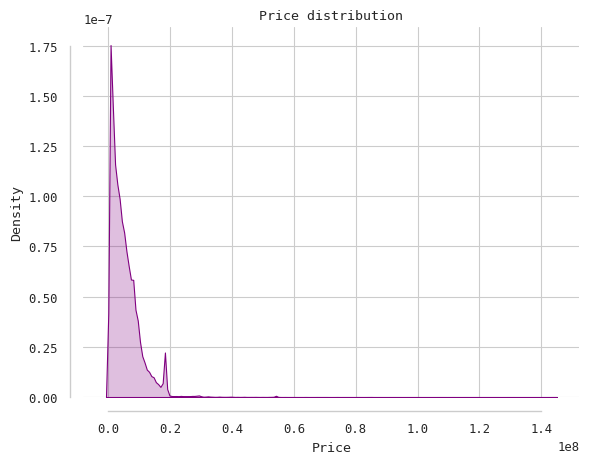

In [ ]:
sns.kdeplot(df, x= 'price', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

**Mileage**

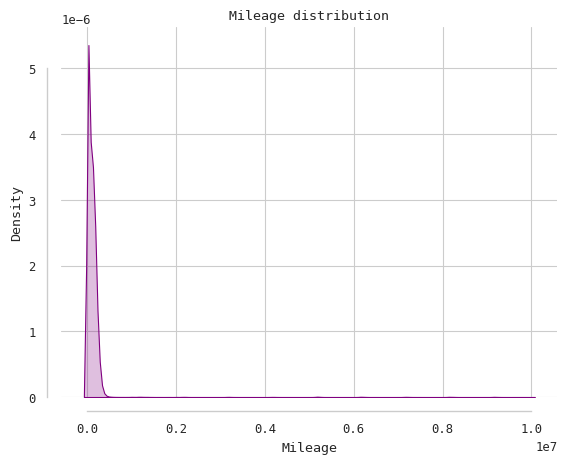

In [ ]:
sns.kdeplot(df, x= 'mileage', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Mileage distribution')
plt.xlabel('Mileage')
plt.ylabel('Density')
plt.show()

In [ ]:
df.mileage.describe()

count    603981.00
mean     115283.86
std      365012.42
min           0.00
25%       22000.00
50%       82500.00
75%      150000.00
max     9999999.00
Name: mileage, dtype: float64

A zero minimum value and substantial difference between the maximum value and the 75th percentile implies the presence of outliers.
I will winorize the data between the 10th and 90th percentiles.

In [ ]:
max_mileage= round(df['mileage'].quantile(0.9))
min_mileage= round(df['mileage'].quantile(0.1))

# replacing outliers with capped values.
df.loc[df['mileage'] > max_mileage, 'mileage'] = max_mileage
df.loc[df['mileage'] < min_mileage, 'mileage'] = min_mileage

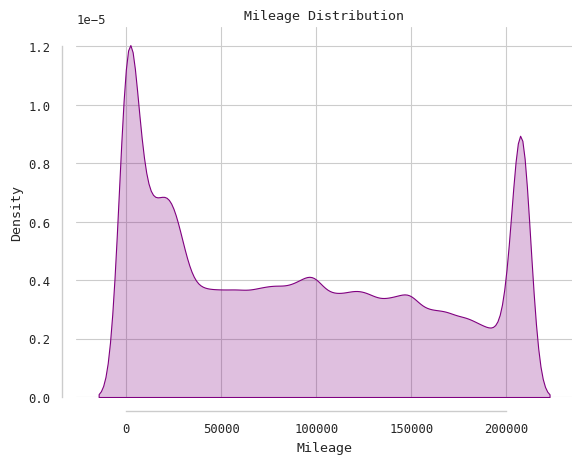

In [ ]:
sns.kdeplot(df, x= 'mileage', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.ylabel('Density')
plt.show()

**Engine displacement.**

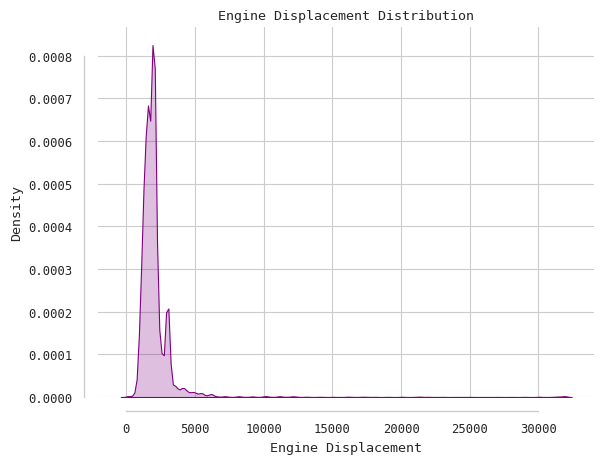

In [ ]:
sns.kdeplot(df, x= 'engine_displacement', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Engine Displacement Distribution')
plt.xlabel('Engine Displacement')
plt.ylabel('Density')
plt.show()

In [ ]:
df['engine_displacement'].describe()

count   489134.00
mean      2100.23
std       1931.07
min         10.00
25%       1461.00
50%       1898.00
75%       2143.00
max      32000.00
Name: engine_displacement, dtype: float64

When handling the `engine_displacement` column, I will filter values less than 1000 cc and higher than 5000 cc.

In [ ]:
df.loc[df['engine_displacement'] < 1000, 'engine_displacement'] = np.nan
df.loc[df['engine_displacement'] > 5000, 'engine_displacement'] = np.nan

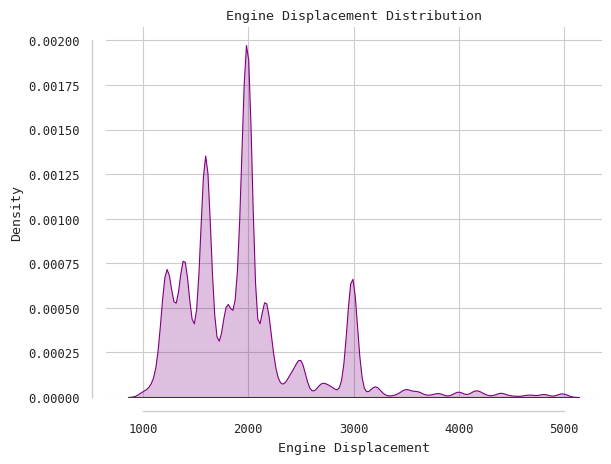

In [ ]:
sns.kdeplot(df, x= 'engine_displacement', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Engine Displacement Distribution')
plt.xlabel('Engine Displacement')
plt.ylabel('Density')
plt.show()

**Engine power**

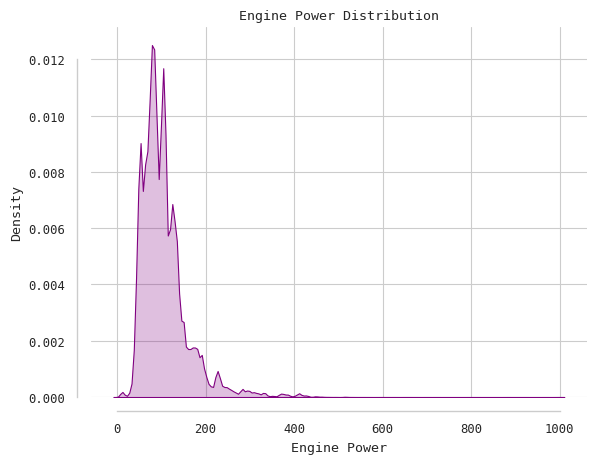

In [ ]:
sns.kdeplot(df, x= 'engine_power', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Engine Power Distribution')
plt.xlabel('Engine Power')
plt.ylabel('Density')
plt.show()

In [ ]:
df['engine_power'].describe()

count   537375.00
mean       105.05
std         53.30
min          3.00
25%         73.00
50%         94.00
75%        125.00
max        999.00
Name: engine_power, dtype: float64

I will filter column values less than 50 HP and  greater than 650 HP.

In [ ]:
df.loc[df['engine_power'] < 50, 'engine_power']= np.nan
df.loc[df['engine_power'] > 650, 'engine_power'] = np.nan

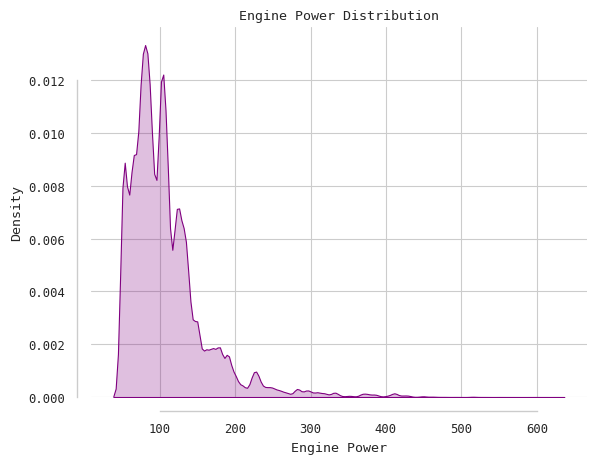

In [ ]:
sns.kdeplot(df, x= 'engine_power', color= 'purple', fill= True)
sns.despine(offset=10, trim=True)
plt.title('Engine Power Distribution')
plt.xlabel('Engine Power')
plt.ylabel('Density')
plt.show()

**Seat count**

In [ ]:
df['seat_count'].value_counts()

seat_count
5.00     535291
4.00      59910
2.00      18954
7.00      15884
3.00       3366
6.00       2154
9.00       1837
8.00        969
1.00         15
12.00        11
10.00         9
14.00         5
17.00         5
11.00         3
18.00         2
16.00         2
15.00         2
19.00         1
22.00         1
56.00         1
23.00         1
74.00         1
50.00         1
54.00         1
45.00         1
20.00         1
Name: count, dtype: int64

Upon closer examination, the `seat_count` column contains unreal values. Consequently, any values exceeding 9 would be filtered out.

In [ ]:
df.loc[(df['seat_count'] > 9), 'seat_count']= np.nan

**Door count**

In [ ]:
df['door_count'].value_counts()

door_count
4.00    498854
2.00     97898
5.00     40138
3.00      1459
6.00       106
1.00         3
Name: count, dtype: int64

In [ ]:
auto= df.copy()

Grouping the cars based on their makes into these four categories:

*   Economy,
*   Luxury,
*   Hypercars, and
*   Off-road vehicles.


In [ ]:
auto.make.unique()

array(['audi', 'bentley', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dodge', 'fiat', 'ford', 'honda', 'hyundai', 'isuzu', 'jaguar',
       'jeep', 'kia', 'lamborghini', 'lancia', 'maserati', 'mazda',
       'mercedes-benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'porsche',
       'rover', 'seat', 'skoda', 'subaru', 'suzuki', 'toyota', 'volvo',
       'hummer', 'lexus', 'tesla', 'lotus', 'smart'], dtype=object)

In [ ]:
class_dict= {'economy': ['chevrolet', 'citroen', 'dodge', 'fiat', 'ford', 'honda', 'hyundai', 'kia', 'mazda', 'mitsubishi', 'nissan',
          'opel', 'seat', 'skoda', 'suzuki', 'subaru', 'toyota', 'smart'],
'luxury': ['audi', 'bentley', 'bmw', 'chrysler', 'jaguar', 'lexus', 'lancia', 'maserati', 'mercedes-benz', 'volvo', 'tesla', 'rover', 'mini'],
'hypercars': ['lamborghini', 'lotus', 'porsche'],
'off_road': ['isuzu', 'jeep', 'hummer']}

auto['class']= auto['make'].apply(lambda x: next((key for key, value in class_dict.items() if x in value), 'other'))

In [ ]:
auto.head()

,make,manufacture_year,fuel_type,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price,class
0,audi,1995,gasoline,a4,208000.00,2600.00,110.00,compact,automatic,4.00,5.00,2015-11-14 20:10:48.033192+00:00,873428,luxury
1,audi,1995,gasoline,200,NaN,NaN,NaN,compact,manual,4.00,5.00,2015-11-14 20:11:19.607788+00:00,719808,luxury
2,audi,1995,gasoline,a4,NaN,NaN,NaN,compact,manual,4.00,5.00,2015-11-14 20:11:20.320579+00:00,719808,luxury
3,audi,1995,gasoline,a4,NaN,NaN,NaN,compact,manual,4.00,5.00,2015-11-14 20:11:21.801285+00:00,719808,luxury
4,audi,1995,gasoline,a6,208000.00,NaN,85.00,compact,automatic,4.00,5.00,2015-11-14 20:12:41.082787+00:00,843820,luxury


**One-Hot Encoding of categorical variables.**

In [ ]:
auto_enc= pd.get_dummies(data= auto, columns= ['fuel_type', 'body_type', 'transmission', 'class'], dtype= 'int64')

In [ ]:
auto= auto_enc.copy()

In [ ]:
price= auto['price']
auto.drop(['date_created', 'price'], axis= 1, inplace= True)
auto['price']= price

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(auto, price, test_size= 0.2, random_state= 42)

In [ ]:
train_auto_num= x_train.select_dtypes(np.number)

**Data Imputation using MICE (Multiple Imputation by Chained Equation)**

For the `mileage`, `engine_displacement`, and `engine_power` columns, I will use the multivariate feature imputation method to fill in the missing values.

In [ ]:
imputer= IterativeImputer(estimator= LGBMRegressor(), imputation_order= 'ascending')

In [ ]:
imputed_arr= imputer.fit_transform(train_auto_num) # imputting the missing values in the numerical columns
num_cols= train_auto_num.columns.tolist() # storing the column names in a list
train_auto_num[num_cols]= imputed_arr # replacing the missing values in the numerical columns with the imputed values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 510849, number of used features: 16
[LightGBM] [Info] Start training from score 2008.724748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 510849, number of used features: 16
[LightGBM] [Info] Start training from score 0.466259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [ ]:
# substituting these values back into the auto dataset
x_train[num_cols]= train_auto_num[num_cols]

In [ ]:
x_train['miles_per_year']= x_train['mileage'] / (2024 - x_train['manufacture_year'])
x_train.drop('price', axis= 1, inplace= True)
x_train['price']= price

In [ ]:
x_train= x_train.astype({'mileage': 'int64', 'engine_displacement': 'int64', 'engine_power': 'int64',
            'door_count': 'int64', 'seat_count': 'int64', 'fuel_type_diesel': 'int64', 'fuel_type_gasoline': 'int64',
                 'transmission_automatic': 'int64',  'transmission_manual': 'int64',  'class_economy': 'int64',
                   'class_luxury': 'int64',  'class_hypercars': 'int64',  'class_off_road': 'int64',
                   'body_type_compact': 'int64', 'body_type_van': 'int64'})

## Feature selection.

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510849 entries, 224516 to 121958
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   make                    510849 non-null  object 
 1   manufacture_year        510849 non-null  float64
 2   model                   510463 non-null  object 
 3   mileage                 510849 non-null  int64  
 4   engine_displacement     510849 non-null  int64  
 5   engine_power            510849 non-null  int64  
 6   door_count              510849 non-null  int64  
 7   seat_count              510849 non-null  int64  
 8   fuel_type_diesel        510849 non-null  int64  
 9   fuel_type_gasoline      510849 non-null  int64  
 10  body_type_compact       510849 non-null  int64  
 11  body_type_van           510849 non-null  int64  
 12  transmission_automatic  510849 non-null  int64  
 13  transmission_manual     510849 non-null  int64  
 14  class_economy       

In [ ]:
features= x_train.drop(['make', 'model'], axis= 1)
target= x_train['price']

**Correlation**

In [ ]:
correlation_matrix= features.corr(numeric_only= True)
matrix= np.triu(correlation_matrix)

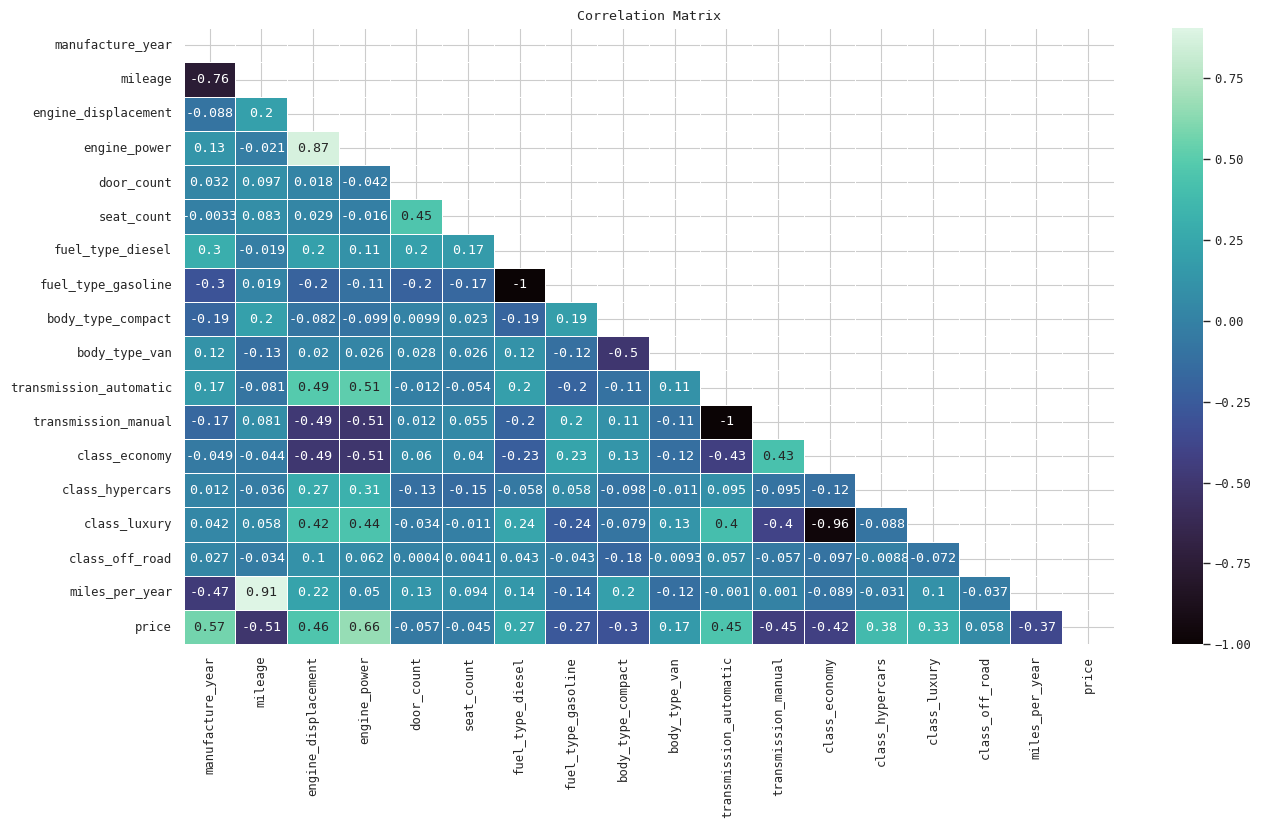

In [ ]:
plt.subplots(figsize = (15, 8))
sns.heatmap(correlation_matrix, cmap= 'mako', annot= True, linewidth= .5, mask= matrix
            #annot_kws= {'fontweight': 'bold'}
            )
plt.title('Correlation Matrix')
plt.show()

From the heatmap, we can infer that:

1.   `manufacture_year`, and `mileage` are highly correlated.
2. `engine_displacement` and `engine_power` have a strong correlation. `engine_displacement` would be dropped as a predictive feature.
3. `mileage` and `miles_per_year` are highly correlated.
4. There is an inverse relationship betweeen `fuel_type_diesel` and `fuel_type_gasoline`, `class_conomy` and `class_luxury` & `transmission_automatic` and `transmission_manual`.



In [ ]:
X= features.drop(columns= ['fuel_type_diesel', 'transmission_manual', 'mileage', 'class_economy', 'price'], axis= 1)
Y= features['price'].to_numpy()
Y= np.log(Y)

## Building the model

In [ ]:
# splitting into train and test sets
print(f'Training data shape: {X.shape}')
print(f'Target shape: {Y.shape}')

Training data shape: (510849, 13)
Test data shape: (510849,)


**Standardizing the data**

In [ ]:
standard_scaler= StandardScaler()
min_max_scaler= MinMaxScaler()
scaled_train= standard_scaler.fit_transform(X)

**Hyperparameter tuning**

In [ ]:
estimator= LGBMRegressor() # initializing the model
param_grid= {
    'num_leaves': [16, 32, 64, 100, 1000],
    'learning_rate': [0.05, 0.1],
    'min_data_in_leaf': [500, 1000, 2500],
    'max_depth': [4, 5, 6, 7]
    }
cv= KFold(shuffle= True, random_state= 42)

grid_search= GridSearchCV(estimator= estimator, param_grid= param_grid, cv= cv, scoring= 'neg_mean_squared_error', n_jobs= -1)

In [ ]:
grid_search.fit(X, Y)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 510849, number of used features: 13
[LightGBM] [Info] Start training from score 15.021974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [4, 5, 6, 7],
                         'min_data_in_leaf': [500, 1000, 2500],
                         'num_leaves': [16, 32, 64, 100, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'The best parameters for the are {grid_search.best_params_}')

The best parameters for the are {'learning_rate': 0.1, 'max_depth': 7, 'min_data_in_leaf': 500, 'num_leaves': 1000}


In [ ]:
# initiating the moel
# estimator= LGBMRegressor()
# choosing hyperparameters
best_parameters= {
    'num_leaves': [1000],
    'learning_rate': [0.1],
    'min_data_in_leaf': [500],
    'max_depth': [7]
    }
# cross-validation
# cv= KFold(n_splits= 5, shuffle= True, random_state= 42)

In [ ]:
model= GridSearchCV(
    estimator= estimator, param_grid= best_parameters, cv= cv, scoring= 'neg_mean_squared_error',
    n_jobs= -1, verbose= 0)

model.fit(X, Y)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 510849, number of used features: 13
[LightGBM] [Info] Start training from score 15.021974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'min_data_in_leaf': [500], 'num_leaves': [1000]},
             scoring='neg_mean_squared_error')

**Test Data manipulation.**

In [ ]:
test_auto_num= x_test.select_dtypes(np.number)

imputed_arr_test= imputer.fit_transform(test_auto_num) # imputting the missing values in the numerical columns
num_cols_test= test_auto_num.columns.tolist() # storing the column names in a list
test_auto_num[num_cols]= imputed_arr_test # replacing the missing values in the numerical columns with the imputed values

x_test[num_cols]= test_auto_num[num_cols]

x_test['miles_per_year']= x_test['mileage'] / (2024 - x_test['manufacture_year'])
x_test.drop('price', axis= 1, inplace= True)
x_test['price']= price

x_test= x_test.astype({'mileage': 'int64', 'engine_displacement': 'int64', 'engine_power': 'int64',
            'door_count': 'int64', 'seat_count': 'int64', 'fuel_type_diesel': 'int64', 'fuel_type_gasoline': 'int64',
                 'transmission_automatic': 'int64',  'transmission_manual': 'int64',  'class_economy': 'int64',
                   'class_luxury': 'int64',  'class_hypercars': 'int64',  'class_off_road': 'int64',
                   'body_type_compact': 'int64', 'body_type_van': 'int64'})

test_features= x_test.drop(['make', 'model'], axis= 1)
test_target= x_test['price']

test_X= test_features.drop(columns= ['fuel_type_diesel', 'transmission_manual', 'mileage', 'class_economy', 'price'], axis= 1)
test_Y= test_features['price'].to_numpy()
test_Y= np.log(test_Y)

scaled_test= standard_scaler.transform(test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 127713, number of used features: 16
[LightGBM] [Info] Start training from score 2008.724593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 127713, number of used features: 16
[LightGBM] [Info] Start training from score 0.467439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

**Predictions**

In [ ]:
y_preds= model.predict(scaled_test)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


In [ ]:
print(f'The MSE is: {mean_squared_error(test_Y, y_preds, squared= True)}')
print(f'The R2 score is: {r2_score(test_Y, y_preds)}')

The MSE is: 3.6140414842886437
The R2 score is: -2.398387221552317


In [ ]:
# scaling back the target
target_exp= np.exp(y_test)
# scaling the predictions.
preds_exp= np.exp(y_preds)

In [ ]:
results= pd.DataFrame({'actual': target_exp, 'predicted': preds_exp})
results['predicted']= results['predicted'].astype('int64')
results['actual']= results['actual'].astype('int64')
results.head(5)

In [ ]:
# training the model on the whole dataset
model.fit(X, Y)

In [ ]:
saved_model= pickle.dump(model, open('model.pkl', 'wb'))